In [ ]:
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

Running on PyMC v5.19.1



# $V(x) = k \frac{[(x - x_0)\cos\theta + h\sin\theta]}{[(x - x_0)^2 + h^2]^q}$
q=1.5
***

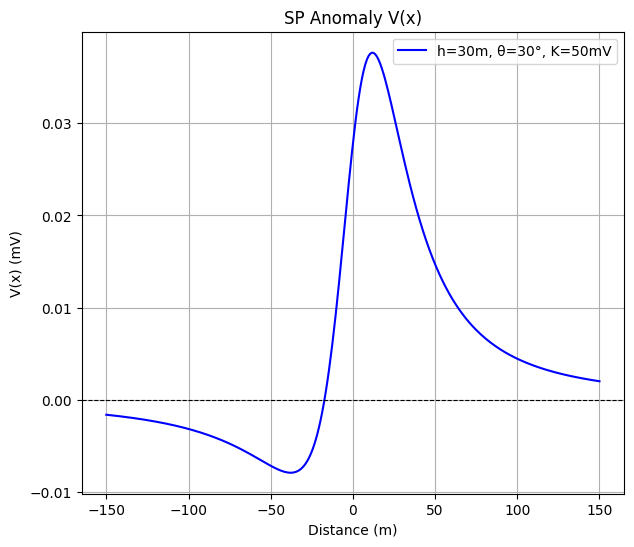

In [ ]:


# Parameters
x0 = 0  # Center of the sphere/cylinder
h = 30  # Depth (m)
theta_deg = 30  # Angle in degrees
K = 50  # SP coefficient (mV)
q = 1.5  # Shape factor for a sphere
x = np.linspace(-150, 150, 300)  # Profile along 300m (x-coordinates)

# Convert theta to radians
theta_rad = np.radians(theta_deg)

# SP anomaly formula
V_x = (K * ((x - x0) * np.cos(theta_rad) + h * np.sin(theta_rad))) / (((x - x0)**2 + h**2)**q)

# Plotting the SP anomaly
plt.figure(figsize=(7, 6))
plt.plot(x, V_x, label=f"h={h}m, θ={theta_deg}°, K={K}mV", color="blue")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("SP Anomaly V(x)")
plt.xlabel("Distance (m)")
plt.ylabel("V(x) (mV)")
plt.legend()
plt.grid()
plt.show()

# Save the x and V(x) values for further reference
data = np.column_stack((x, V_x))
np.savetxt("SP_anomaly_h30_theta30_k50.csv", data, delimiter=",", header="Distance(m),V(x)(mV)", comments='')


# Bayesian Analysis with PyMC3
***

# Priors:
- $K \sim \text{Exponential}(\lambda=1/50)$
- $h \sim \mathcal{N}(\mu=30, \sigma=10)$
- $\theta \sim \mathcal{N}(\mu=\pi/6, \sigma=\pi/18)$
- $q \sim \mathcal{N}(\mu=1.5, \sigma=0.5)$
- $\sigma \sim \text{Exponential}(\lambda=1/5)$

---

# Likelihood:
$V_x^{\text{obs}} | K, h, \theta, q, \sigma \sim \mathcal{N}\left(K \cdot \frac{x \cos(\theta) + h \sin(\theta)}{(x^2 + h^2)^{q/2}}, \sigma \right)$

---

# Posterior:
$P(K, h, \theta, q, \sigma | V_x^{\text{obs}}) \propto P(V_x^{\text{obs}} | K, h, \theta, q, \sigma) \cdot P(K) \cdot P(h) \cdot P(\theta) \cdot P(q) \cdot P(\sigma)$

***

Output()

ERROR:pymc.stats.convergence:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


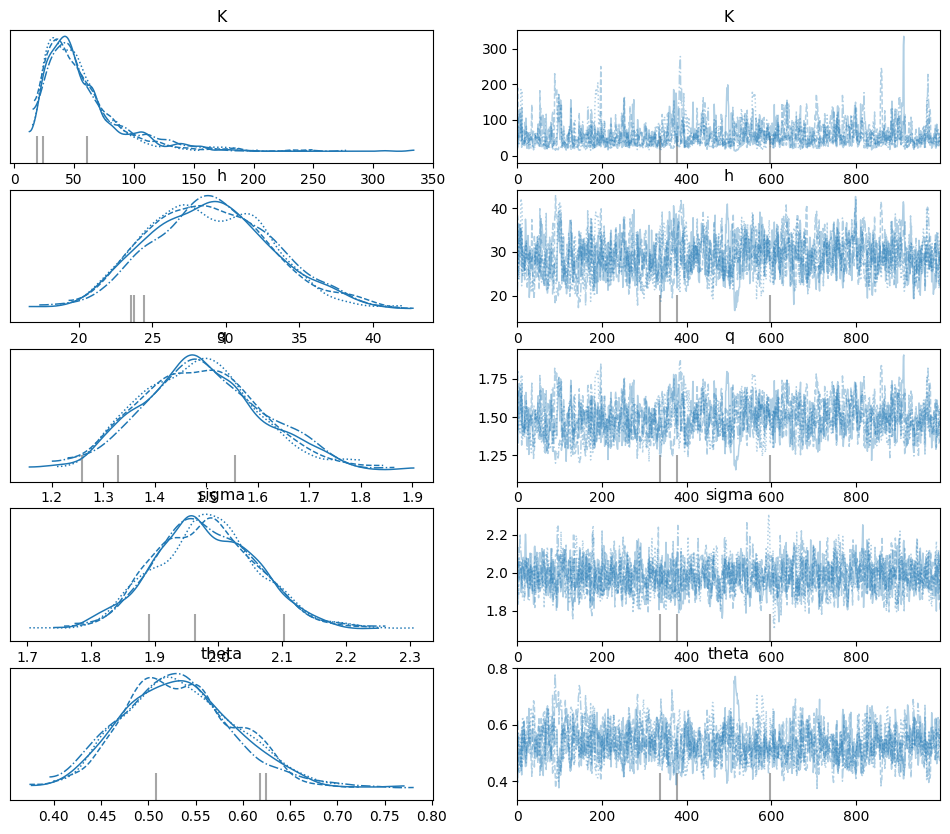

Output()

KeyError: 'V_x_obs'

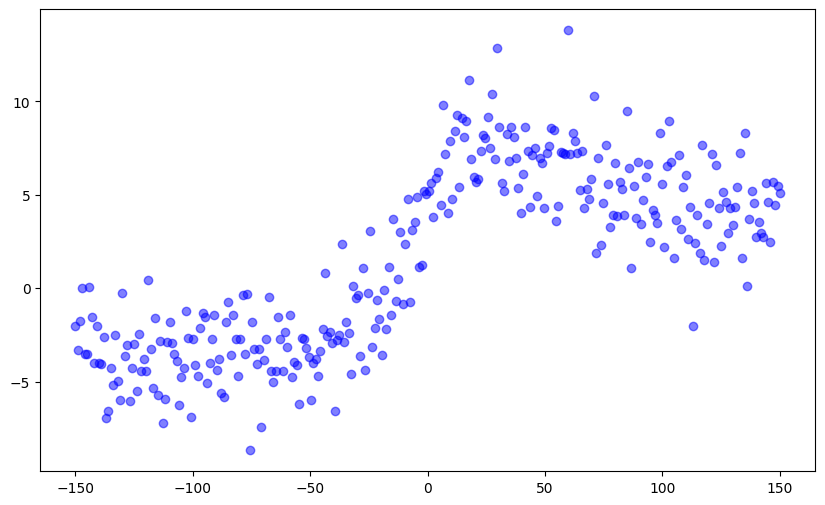

In [3]:


# Simulated data
np.random.seed(42)
x_vals = np.linspace(-150, 150, 300)
K_true = 50
h_true = 30
theta_true = np.radians(30)  # Convert degrees to radians
q_true = 1.5  # Assumed shape factor
sigma_true = 2

# SP anomaly calculation with Gaussian noise
numerator = (x_vals * np.cos(theta_true) + h_true * np.sin(theta_true))
denominator = ((x_vals) ** 2 + h_true ** 2) ** (q_true / 2)
V_x_true = K_true * (numerator / denominator)
noise = np.random.normal(0, sigma_true, len(x_vals))
V_x_obs = V_x_true + noise

# Define the PyMC model
with pm.Model() as model:
    # Priors for parameters
    K = pm.Exponential("K", lam=1 / 50)  # Prior for K
    h = pm.Normal("h", mu=10, sigma=40)  # Prior for h
    theta = pm.Normal("theta", mu=np.radians(10), sigma=np.radians(40))  # Prior for theta in radians
    q = pm.Normal("q", mu=0, sigma=2)  # Prior for q
    sigma = pm.Exponential("sigma", lam=1 / 5)  # Prior for Gaussian noise

    # Expected SP anomaly
    numerator = x_vals * pm.math.cos(theta) + h * pm.math.sin(theta)
    denominator = (x_vals ** 2 + h ** 2) ** (q / 2)
    V_x = K * (numerator / denominator)

    # Likelihood
    likelihood = pm.Normal("V_x_obs", mu=V_x, sigma=sigma, observed=V_x_obs)

    # Posterior sampling
    trace = pm.sample(1000, return_inferencedata=True, cores=4)

# Plot the results
import arviz as az

az.plot_trace(trace)
plt.show()

# Posterior predictive check
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["V_x_obs"])

# Plot observed vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(x_vals, V_x_obs, color="blue", label="Observed", alpha=0.5)
plt.plot(x_vals, np.mean(posterior_predictive["V_x_obs"], axis=0), color="red", label="Predicted")
plt.fill_between(
    x_vals,
    np.percentile(posterior_predictive["V_x_obs"], 2.5, axis=0),
    np.percentile(posterior_predictive["V_x_obs"], 97.5, axis=0),
    color="red",
    alpha=0.3,
    label="95% CI",
)
plt.xlabel("x (m)")
plt.ylabel("V(x) (mV)")
plt.title("Observed vs Predicted SP Anomaly")
plt.legend()
plt.grid()
plt.show()


In [4]:


print(az.summary(posterior_predictive))  # Summary of the posterior predictive
print(posterior_predictive.posterior_predictive)  # Check the available variables



/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1357: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
V_x_obs[0]   -3.089  1.997  -6.809    0.640      0.031    0.022    4088.0   
V_x_obs[1]   -3.199  2.014  -7.004    0.518      0.033    0.023    3732.0   
V_x_obs[2]   -3.127  2.045  -6.982    0.622      0.032    0.022    4156.0   
V_x_obs[3]   -3.202  2.025  -6.957    0.625      0.033    0.023    3822.0   
V_x_obs[4]   -3.184  1.992  -7.019    0.609      0.032    0.023    3826.0   
...             ...    ...     ...      ...        ...      ...       ...   
V_x_obs[295]  3.974  2.010   0.294    7.905      0.032    0.023    3888.0   
V_x_obs[296]  4.019  2.004   0.244    7.753      0.032    0.023    4000.0   
V_x_obs[297]  4.005  1.991   0.499    7.969      0.032    0.023    3940.0   
V_x_obs[298]  3.992  2.019   0.217    7.818      0.032    0.023    3970.0   
V_x_obs[299]  3.983  1.973   0.216    7.649      0.032    0.022    3920.0   

              ess_tail  r_hat  
V_x_obs[0]      3968.0    1.0  
V_x_obs[1] 

In [5]:
predicted_V_x_obs = posterior_predictive.posterior_predictive["V_x_obs"].values


# Generate Data
***

(4000, 300)


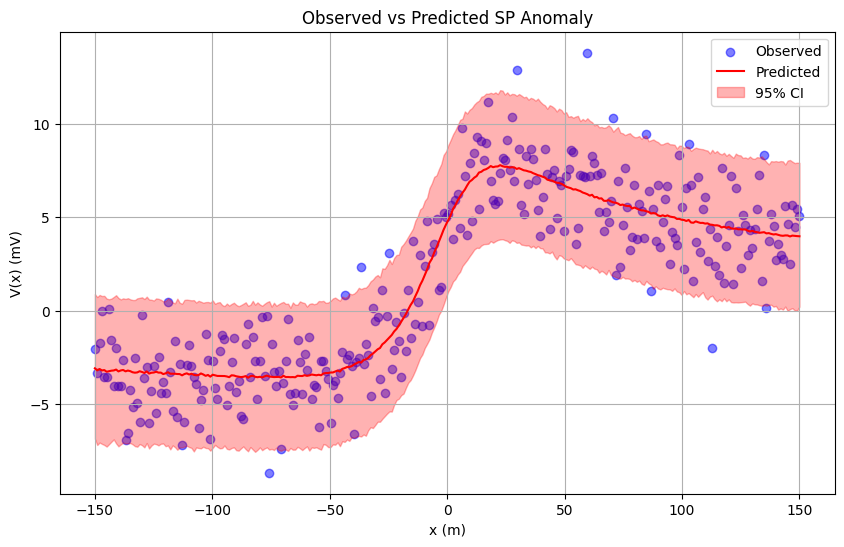

In [6]:

predicted_V_x_obs_flattened = predicted_V_x_obs.reshape(-1, predicted_V_x_obs.shape[-1])  # Shape: (4000, 300)


print(predicted_V_x_obs_flattened.shape)
# Compute the mean and confidence intervals for the posterior predictive
mean_predicted = np.mean(predicted_V_x_obs_flattened, axis=0)  # Shape: (300,)
lower_bound = np.percentile(predicted_V_x_obs_flattened, 2.5, axis=0)  # 2.5th percentile
upper_bound = np.percentile(predicted_V_x_obs_flattened, 97.5, axis=0)  # 97.5th percentile

# Plot observed vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(x_vals, V_x_obs, color="blue", label="Observed", alpha=0.5)  # Observed data
plt.plot(x_vals, mean_predicted, color="red", label="Predicted")  # Mean prediction
plt.fill_between(
    x_vals,
    lower_bound,
    upper_bound,
    color="red",
    alpha=0.3,
    label="95% CI",  # Confidence interval
)
plt.xlabel("x (m)")
plt.ylabel("V(x) (mV)")
plt.title("Observed vs Predicted SP Anomaly")
plt.legend()
plt.grid()
plt.show()


# Visualization of posterior distributions for SP model parameters

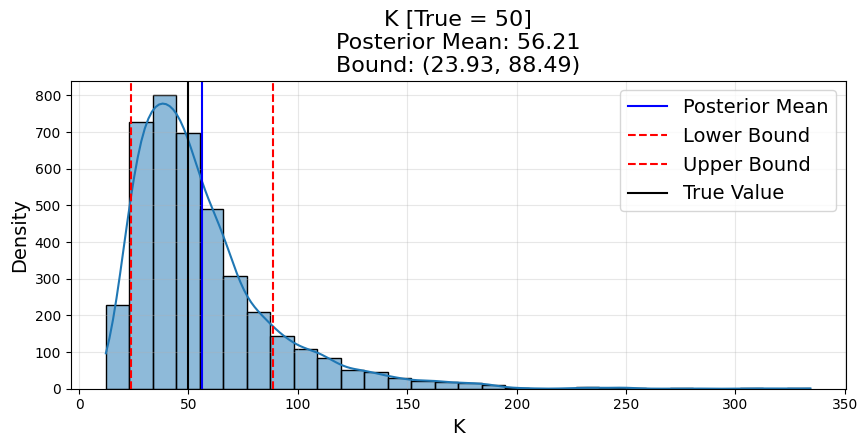

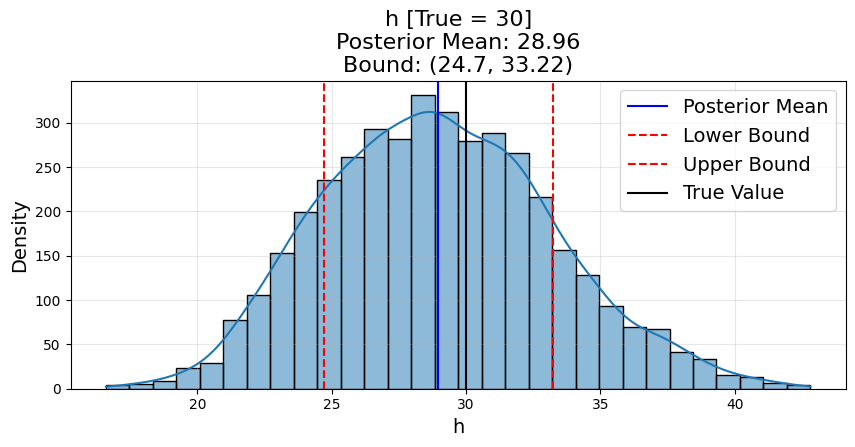

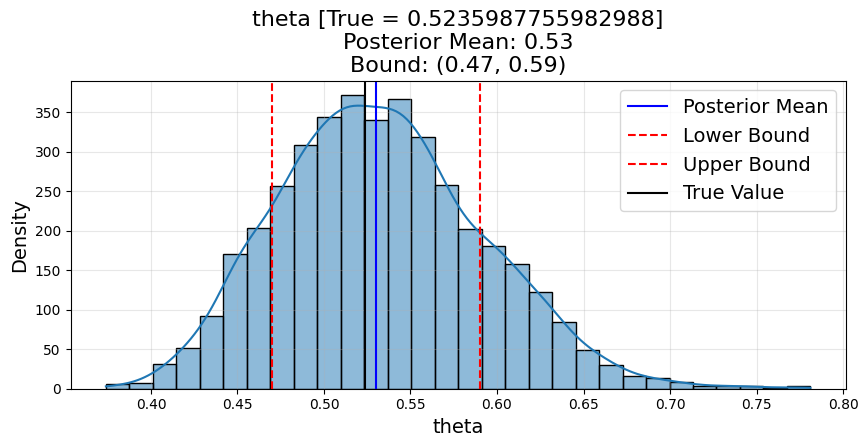

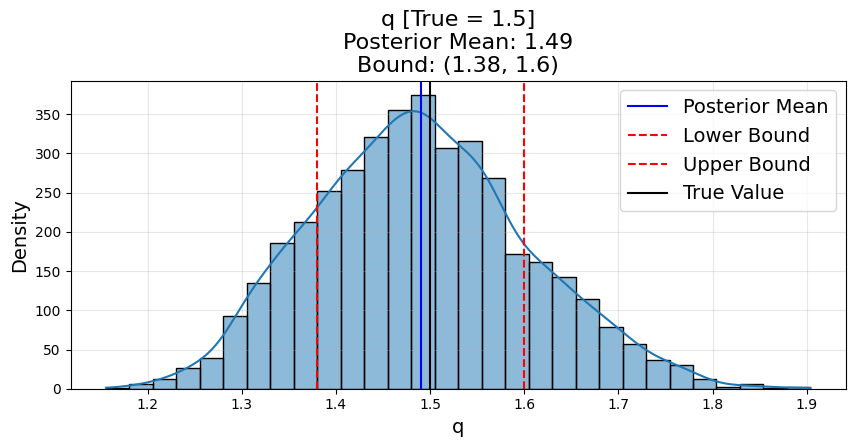

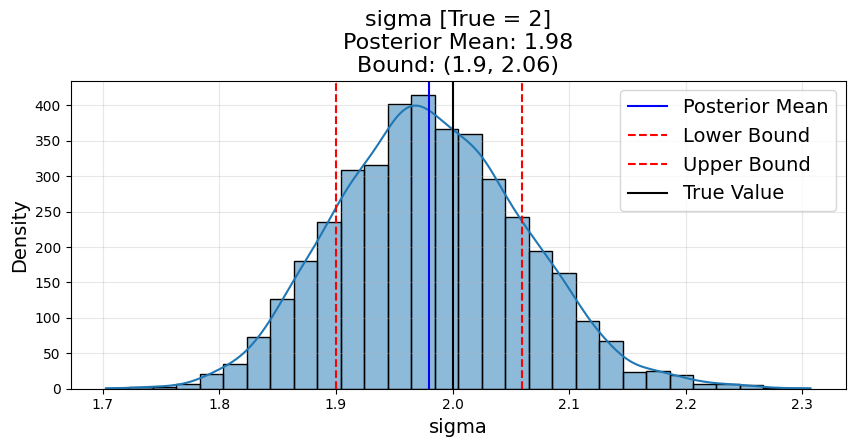

In [7]:



params = ['K', 'h', 'theta', 'q', 'sigma']
true_params = {'K': K_true, 'h': h_true, 'theta': theta_true, 'q': q_true, 'sigma': sigma_true}

for var in params:
    plt.figure(figsize=(10, 4))
    vals = trace.posterior[var].values.flatten()  # Flatten the posterior samples for the variable
    mean = round(vals.mean(), 2)
    lower = round(mean - vals.std(), 2)
    upper = round(mean + vals.std(), 2)

    sns.histplot(vals, kde=True, bins=30)
    posterior_est = plt.axvline(mean, color='b', label='Posterior Mean')

    plt.axvline(lower, color='r', linestyle='--', label='Lower Bound')
    plt.axvline(upper, color='r', linestyle='--', label='Upper Bound')

    plt.title(f"{var} [True = {true_params[var]}]\nPosterior Mean: {mean}\nBound: ({lower}, {upper})", fontsize=16)
    true_val = plt.axvline(true_params[var], color='k', label='True Value')

    plt.legend(fontsize=14)
    plt.xlabel(var, fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.grid(alpha=0.3)
    plt.show()
